In [ ]:
!pip install hmmlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 kB 3.9 MB/s eta 0:00:00


In [40]:
"""
Updated Gaussian HMM Financial Time Series Analysis
"""
import os
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

try:
    from hmmlearn.hmm import GaussianHMM
except Exception as e:
    raise ImportError("hmmlearn is required.")

import yfinance as yf

UPLOADED_IMAGE = '/mnt/data/bedcf456-6476-4678-88b9-fdccdc6f6f3e.png'


In [41]:
def download_data(ticker, start_date, end_date, auto_adjust=True):
    df = yf.download(ticker, start=start_date, end=end_date, progress=False, auto_adjust=auto_adjust)
    if df.empty:
        raise ValueError()
    if auto_adjust:
        if 'Close' in df.columns:
            df = df[['Close']].rename(columns={'Close': 'adj_close'})
        else:
            raise KeyError()
    else:
        if 'Adj Close' in df.columns:
            df = df[['Adj Close']].rename(columns={'Adj Close': 'adj_close'})
        else:
            if 'Close' in df.columns:
                df = df[['Close']].rename(columns={'Close': 'adj_close'})
            else:
                raise KeyError()
    df.index = pd.to_datetime(df.index)
    return df


In [42]:
def compute_returns(df, method='log'):
    df = df.copy()
    if method == 'log':
        df['log_return'] = np.log(df['adj_close']).diff()
    elif method == 'pct':
        df['log_return'] = df['adj_close'].pct_change()
    else:
        raise ValueError()
    df = df.dropna()
    return df


In [43]:
def fit_gaussian_hmm(returns, n_states=2, covariance_type='full', n_iter=200, random_state=42):
    X = returns.values.reshape(-1, 1)
    model = GaussianHMM(n_components=n_states, covariance_type=covariance_type, n_iter=n_iter, random_state=random_state)
    model.fit(X)
    states = model.predict(X)
    return model, states


In [51]:
def analyze_states(model):
    means = model.means_.flatten()
    cov_type = model.covariance_type
    if cov_type == 'diag':
        variances = model.covars_.flatten()
    elif cov_type == 'full':
        variances = np.array([cov[0, 0] for cov in model.covars_])
    else:
        try:
            variances = model.covars_.flatten()
        except Exception:
            variances = np.zeros_like(means)
    pi = model.startprob_
    trans = model.transmat_
    df = pd.DataFrame({
        'state': np.arange(len(means)),
        'mean_return': means,
        'variance': variances,
        'initial_prob': pi
    }).set_index('state')
    return df, trans


In [52]:
def plot_regimes(df, states, ticker, savepath=None):
    dates = df.index
    price = df['adj_close']
    returns = df['log_return']
    fig, axes = plt.subplots(2, 1, figsize=(8, 8), sharex=True, gridspec_kw={'height_ratios': [2, 1]})
    ax_price, ax_ret = axes
    ax_price.plot(dates, price, lw=1.2)
    ax_price.set_ylabel('Adj Close Price')
    ax_price.set_title(f'{ticker} Price and HMM Regimes')
    unique_states = np.unique(states)
    palette = sns.color_palette('tab10', n_colors=len(unique_states))
    for state_idx, state in enumerate(unique_states):
        mask = (states == state)
        idx = np.where(mask)[0]
        if idx.size == 0:
            continue
        splits = np.split(idx, np.where(np.diff(idx) != 1)[0] + 1)
        color = palette[state_idx]
        for block in splits:
            ax_price.axvspan(dates[block[0]], dates[block[-1]], color=color, alpha=0.12)
    for state_idx, state in enumerate(unique_states):
        mask = (states == state)
        ax_ret.scatter(dates[mask], returns[mask], s=10, label=f'State {state}', alpha=0.9)
    ax_ret.set_ylabel('Log Return')
    ax_ret.set_xlabel('Date')
    ax_ret.legend()
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=150)
    plt.show()


In [53]:
def plot_state_histograms(df, states, model, savepath=None):
    returns = df['log_return'].values
    dates = df.index
    n_states = model.n_components
    fig, axes = plt.subplots(n_states, 1, figsize=(8, 3 * n_states))
    if n_states == 1:
        axes = [axes]
    x_grid = np.linspace(returns.min(), returns.max(), 300)
    for s in range(n_states):
        ax = axes[s]
        rs = returns[states == s]
        ax.hist(rs, bins=50, density=True, alpha=0.6)
        mu = model.means_[s, 0]
        if model.covariance_type == 'full':
            sigma = np.sqrt(model.covars_[s][0, 0])
        else:
            try:
                sigma = np.sqrt(model.covars_[s].flatten()[0])
            except Exception:
                sigma = 0.0
        if sigma > 0:
            pdf = 1.0 / (np.sqrt(2 * np.pi) * sigma) * np.exp(-0.5 * ((x_grid - mu) / sigma) ** 2)
            ax.plot(x_grid, pdf, lw=2)
        ax.set_title(f'State {s}: mean={mu:.5f}, sigma={sigma:.5f}, n_points={len(rs)}')
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=150)
    plt.show()


In [66]:
def plot_transition_matrix(trans, state_names=None, cmap="YlOrRd", annot_fmt=".3f", savepath=None):
    trans = np.array(trans)
    n_states = trans.shape[0]
    if state_names is None:
        state_names = [f"State {i}" for i in range(n_states)]
    trans_df = pd.DataFrame(trans, index=[f"From {s}" for s in state_names], columns=[f"To {s}" for s in state_names])
    plt.figure(figsize=(10, 6))
    ax = sns.heatmap(trans_df, annot=True, fmt=annot_fmt, cmap=cmap, cbar_kws={'label': 'Probability'},
                     linewidths=0.5, linecolor='white', square=False)
    ax.set_title("State Transition Probabilities Matrix", fontsize=16, pad=12)
    ax.set_xlabel("")
    ax.set_ylabel("")
    plt.xticks(rotation=20)
    plt.yticks(rotation=0)
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=180, bbox_inches='tight')
    plt.show()


In [67]:
def print_transition_matrix(trans):
    print("Transition Matrix (rows -> from-state, cols -> to-state):")
    print(np.round(trans, 4))


In [68]:
def most_likely_next_state(model, recent_state=None):
    trans = model.transmat_
    if recent_state is None:
        prob_next = model.startprob_.dot(trans)
    else:
        prob_next = trans[int(recent_state)]
    next_state = int(np.argmax(prob_next))
    return next_state, prob_next


       mean_return  variance   initial_prob
state                                      
0         0.001523  0.000045   1.000000e+00
1         0.000348  0.000069   2.504240e-19
2        -0.001609  0.000449  6.706614e-313
Transition Matrix (rows -> from-state, cols -> to-state):
[[0.1233 0.8767 0.    ]
 [0.9739 0.0068 0.0192]
 [0.0213 0.0232 0.9556]]


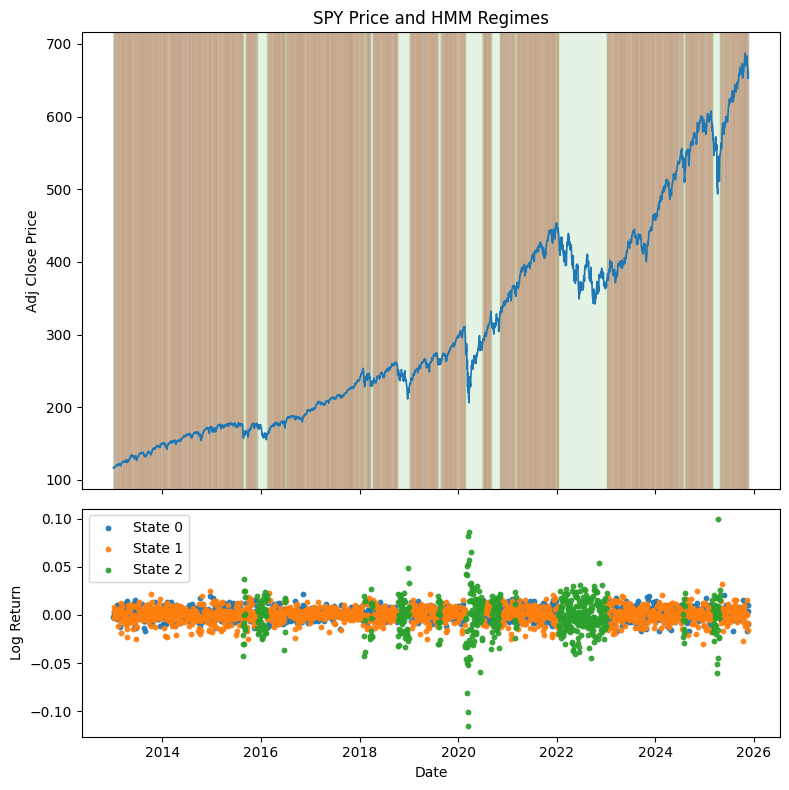

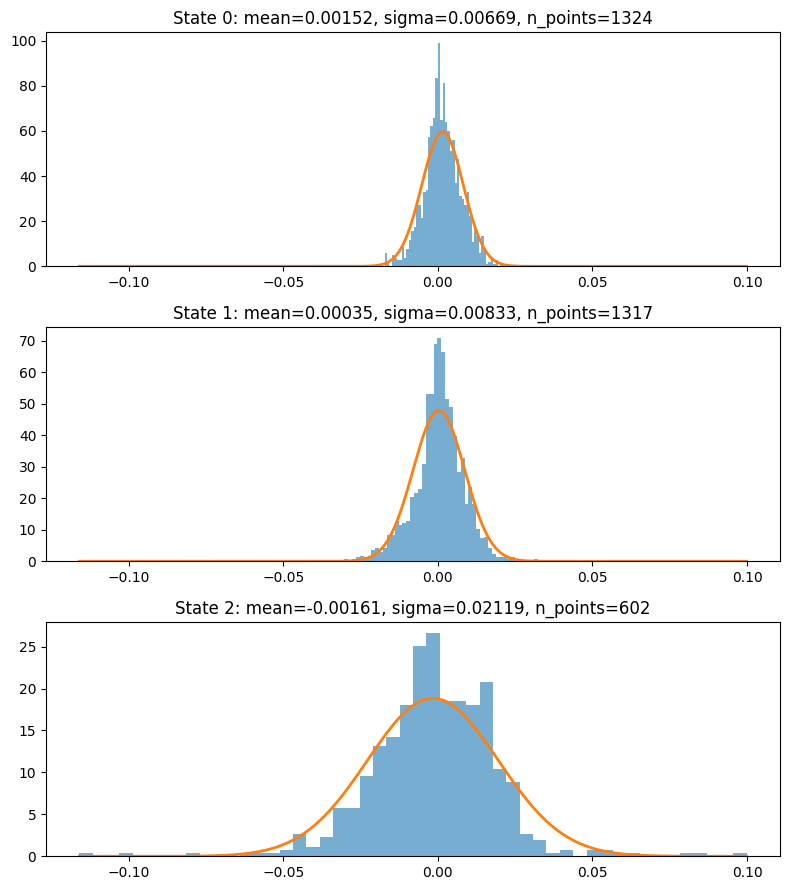

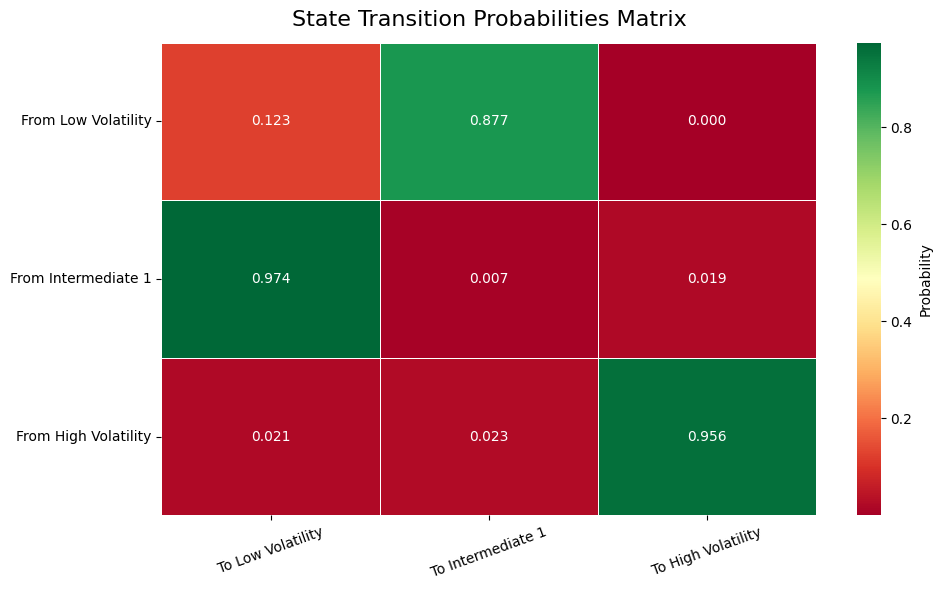

0
1 [0.1233 0.8767 0.    ]
10787.47


10769.36
10923.88
hmm_plots
/mnt/data/bedcf456-6476-4678-88b9-fdccdc6f6f3e.png


In [69]:
if __name__ == '__main__':
    TICKER = 'SPY'
    START_DATE = '2013-01-01'
    END_DATE = datetime.today().strftime('%Y-%m-%d')
    N_STATES = 3
    AUTO_ADJUST = True
    COV_TYPE = 'full'
    RANDOM_STATE = 42

    plot_dir = 'hmm_plots'
    os.makedirs(plot_dir, exist_ok=True)

    df = download_data(TICKER, START_DATE, END_DATE, auto_adjust=AUTO_ADJUST)
    df = compute_returns(df, method='log')

    model, states = fit_gaussian_hmm(df['log_return'], n_states=N_STATES, covariance_type=COV_TYPE, random_state=RANDOM_STATE)
    try:
        converged = model.monitor_.converged
    except Exception:
        converged = True

    state_df, trans = analyze_states(model)
    print(state_df)
    print_transition_matrix(trans)

    df = df.assign(state=states)

    plot_regimes(df, states, TICKER, savepath=os.path.join(plot_dir, f'{TICKER}_regimes.png'))
    plot_state_histograms(df, states, model, savepath=os.path.join(plot_dir, f'{TICKER}_state_histograms.png'))

    example_labels = [f"State {i}" for i in range(N_STATES)]
    means = state_df['mean_return'].values
    variances = state_df['variance'].values
    volatility_rank = np.argsort(variances)
    descriptive_labels = [None] * N_STATES
    for rank, s in enumerate(volatility_rank):
        if rank == 0:
            descriptive_labels[s] = "Low Volatility"
        elif rank == N_STATES - 1:
            descriptive_labels[s] = "High Volatility"
        else:
            descriptive_labels[s] = f"Intermediate {rank}"
    label_list = descriptive_labels

    cmap_choice = 'RdYlGn'
    heatmap_path = os.path.join(plot_dir, f'{TICKER}_transition_matrix.png')
    plot_transition_matrix(trans, state_names=label_list, cmap=cmap_choice, savepath=heatmap_path)

    recent_state = int(states[-1])
    next_state, probs = most_likely_next_state(model, recent_state)
    print(recent_state)
    print(next_state, np.round(probs, 4))

    for k in [2, 3, 4]:
        try:
            m = GaussianHMM(n_components=k, covariance_type='full', n_iter=200, random_state=RANDOM_STATE)
            m.fit(df['log_return'].values.reshape(-1, 1))
            score = m.score(df['log_return'].values.reshape(-1, 1))
            print(f"{score:.2f}")
        except Exception as e:
            print(f"{e}")

    print(plot_dir)
    print(UPLOADED_IMAGE)
